In [1]:
import numpy as np
import pyamg
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression

from scipy.sparse.linalg import eigsh

import scipy
%matplotlib notebook

In [2]:
grid_sizes = [ 5, 10,
              15, 20, 
              25, 30, 
              35, 40, 
              45, 50,
              55, 60,
              65, 70,
              75, 80,
              85, 90,
              95, 100] #20 total

scales = [1e-7, 5e-7,
          1e-6, 5e-6, 
          1e-5, 5e-5, 
          1e-4, 5e-4, 
          1e-3, 5e-3,]

In [3]:
runs_per = 10

def cg(A, b):
    return pyamg.krylov.cg(A, b, tol=1e-8, maxiter=min(A.shape[0],1000))[0]

def mg(A, b):
    return pyamg.ruge_stuben_solver(A).solve(b, tol=1e-8)

def sd(A, b):
    return pyamg.krylov.steepest_descent(A, b, tol=1e-8)[0]

def gmres(A, b):
    return pyamg.krylov.gmres(A, b, tol=1e-8, maxiter=min(A.shape[0],1000))[0]

methods = [("CG",cg), ("MG",mg), ("SD", sd), ("GMRES", gmres)]

In [4]:
results_df2 = pd.DataFrame(columns=['Method','N','sigma','run','norm(eps)','norm(y-x-eps)','norm(y-x)'])

for grid_i in range(len(grid_sizes)):
    temp_data = []
    print("Grid: ", grid_i)
    n = grid_sizes[grid_i]

    A = pyamg.gallery.poisson((n,n), format='csr')

    for scale_i in range(len(scales)):
        print("    Scale: ", scale_i)

        for run_i in range(runs_per):
            b = np.random.rand(A.shape[0])
            E = np.random.normal(scale=scales[scale_i], size=(b.shape))
            bp = b + A @ E
            
            for method_i in range(len(methods)):
                name, solver = methods[method_i]
                x = solver(A, b)
                xp = solver(A, bp)

                temp_data.append({
                    'Method':name,
                    'N':A.shape[0],
                    'sigma':scales[scale_i],
                    'run':run_i,
                    'norm(eps)':np.linalg.norm(E),
                    'norm(y-x-eps)':np.linalg.norm(xp-x-E),
                    'norm(y-x)':np.linalg.norm(xp-x),
                })
                
    results_df2 = results_df2.append(temp_data)

Grid:  0
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6
    Scale:  7
    Scale:  8
    Scale:  9
Grid:  1
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6
    Scale:  7
    Scale:  8
    Scale:  9
Grid:  2
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6
    Scale:  7
    Scale:  8
    Scale:  9
Grid:  3
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6
    Scale:  7
    Scale:  8
    Scale:  9
Grid:  4
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6
    Scale:  7
    Scale:  8
    Scale:  9
Grid:  5
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6
    Scale:  7
    Scale:  8
    Scale:  9
Grid:  6
    Scale:  0
    Scale:  1
    Scale:  2
    Scale:  3
    Scale:  4
    Scale:  5
    Scale:  6

In [5]:
results_df2.to_csv('Poisson_Perturbed_b_v2.csv')

<IPython.core.display.Javascript object>


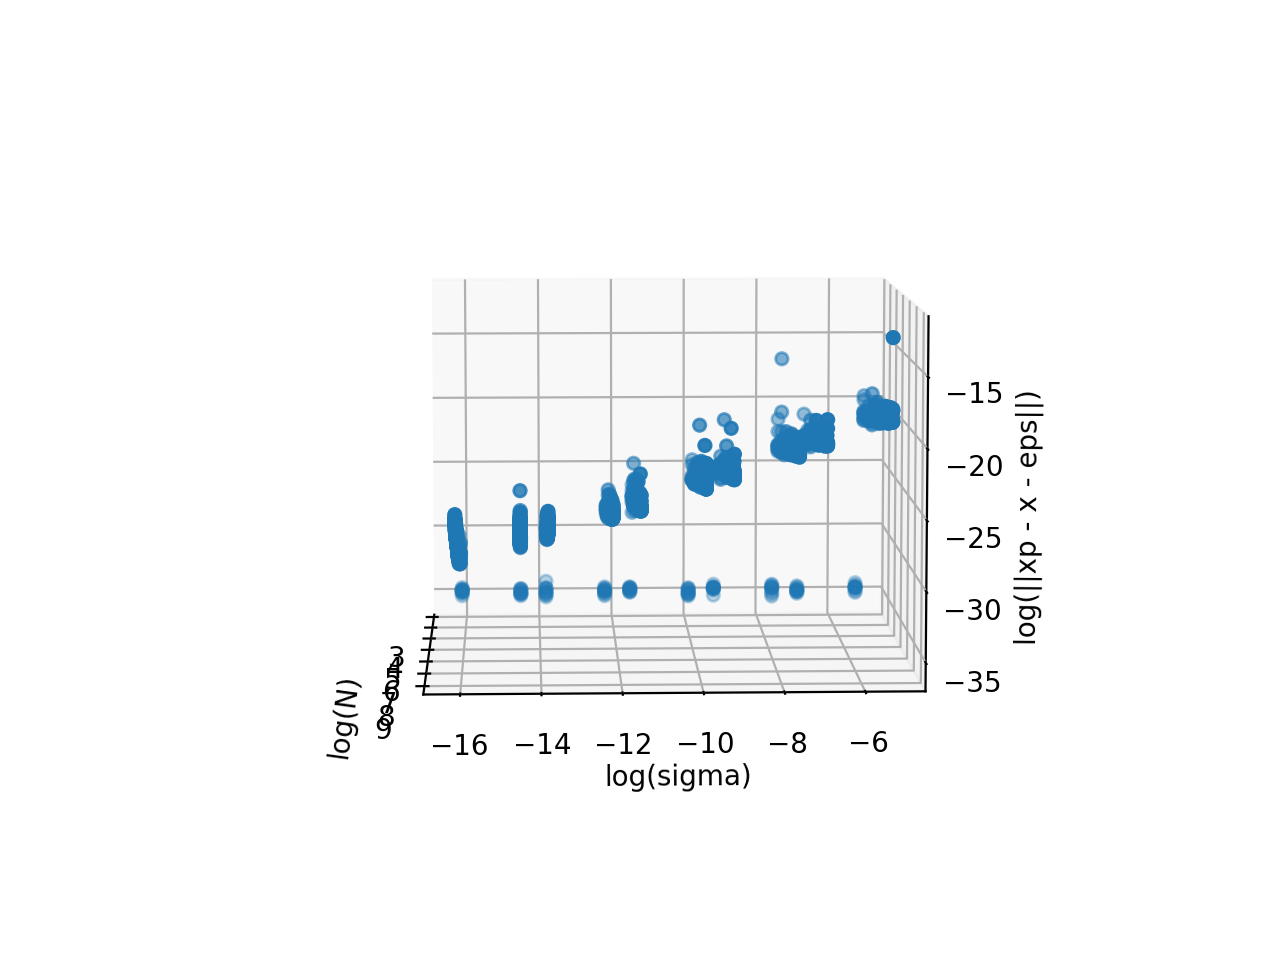

(0.810656648130422, array([1.33692658, 0.81067928]))

In [89]:
method = 'CG'

results_method = results_df2[results_df2['Method']==method]

X = np.log(results_method['N'].astype(float))
Y = np.log(results_method['sigma'])
Z = np.log(results_method['norm(y-x-eps)'])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, cmap='Greens');
ax.set_xlabel('log(N)')
ax.set_ylabel('log(sigma)')
ax.set_zlabel('log(||xp - x - eps||)')

features = np.vstack((X,Y)).T
reg = LinearRegression(normalize=True).fit(features, Z)
reg.score(features, Z), reg.coef_